In [66]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

import datetime
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import textwrap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn import tree


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)


In [2]:
df = pd.read_csv("../data/viewing_rating.csv", encoding='cp932')

In [3]:
# time型に
df.start_at=pd.to_datetime(df.start_at)
# averageの％を削除
df["average"] =  df["average"].apply(lambda x : float(x[:-1]) )


In [4]:
df["start_at_year"] = df["start_at"].dt.year
df["start_at_month"] = df["start_at"].dt.month

In [5]:
df["drama_key"] = df.start_at.dt.strftime("%y")+df.start_at.dt.strftime("%m")+"_"+df.TV_station+"_"+df.time_table

In [6]:
import json

f = open("../data/drama_info.json", 'r')
print(f)
drama_info_json = json.load(f)

<_io.TextIOWrapper name='../data/drama_info.json' mode='r' encoding='UTF-8'>


In [7]:
# def addDramaInfo (drama_title) 
#     main_actor_only_json[drama_title]
    


In [8]:
print (textwrap.shorten(str(drama_info_json), 1000))

{'1910_CX_月21': {'main_actor1': '', 'main_actor2': ''}, '1910_CX_火22': {'main_actor1': '', 'main_actor2': ''}, '1910_TBS_火22': {'main_actor1': '', 'main_actor2': ''}, '1910_NTV_水22': {'main_actor1': '', 'main_actor2': ''}, '1910_EX_木22': {'main_actor1': '', 'main_actor2': ''}, '1910_CX_木22': {'main_actor1': '', 'main_actor2': ''}, '1910_NTV_木23': {'main_actor1': '', 'main_actor2': ''}, '1910_TBS_金22': {'main_actor1': '', 'main_actor2': ''}, '1910_EX_金23': {'main_actor1': '', 'main_actor2': ''}, '1910_NTV_土22': {'main_actor1': '', 'main_actor2': ''}, '1910_EX_土23': {'main_actor1': '', 'main_actor2': ''}, '1910_TBS_日21': {'main_actor1': '', 'main_actor2': ''}, '1910_NTV_日22': {'main_actor1': '', 'main_actor2': ''}, '1907_CX_月21': {'main_actor1': '上野樹里', 'main_actor2': '時任三郎'}, '1907_CX_火21': {'main_actor1': '三浦春馬', 'main_actor2': '芳根京子'}, '1907_TBS_火22': {'main_actor1': '石原さとみ', 'main_actor2': '福士蒼汰'}, '1907_NTV_水22': {'main_actor1': '杏', 'main_actor2': '宮沢氷魚'}, '1907_EX_木21': [...]


In [9]:
df["main_actor1"] = ""
df["main_actor2"] = ""

In [10]:
for tmp_index in range(len(df)):
    tmp_drama_key = df.iloc[tmp_index]["drama_key"]
    if tmp_drama_key in drama_info_json.keys():
#         print(drama_info_json[tmp_drama_key]["main_actor1"])
        df["main_actor1"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor1"]
        df["main_actor2"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor2"]
#         print("yes"+tmp_drama_title)
    else:
        print(tmp_drama_key)

In [11]:
def make_person_key_df (actor_actress):
    actor_actress_list = []
    for column in actor_actress.columns:
        if column == "ranking":
            continue
        actor_actress_list.extend(actor_actress[column].values.tolist())
    print ("元の数"+ str(len(actor_actress_list)))
    # uniqueにする
    actor_actress_list = list(set(actor_actress_list))
    #nan を除去
    actor_actress_list = [actor for actor in actor_actress_list if type(actor) is not float ]
    print ("後の数"+str(len(actor_actress_list)))

    df_pivot = pd.DataFrame( columns=actor_actress_list, index=[str(n) for n in range(2008,2020)])

    #pivot 形式に整形する
    for tmp_name in df_pivot.columns:
        for year in actor_actress.columns:
            if year == "ranking": continue
            if  len(actor_actress[actor_actress[year] == tmp_name].ranking) > 0:
                df_pivot.loc[year][tmp_name] = (actor_actress[actor_actress[year] == tmp_name].ranking).values[0]
    return (df_pivot)
    

In [12]:
df_actress = pd.read_csv("../data/actress_power.csv", encoding='cp932')
df_actress_pivot = make_person_key_df(df_actress)


元の数360
後の数62


In [13]:
df_actor = pd.read_csv("../data/actor_power.csv", encoding='cp932')
df_actor_pivot = make_person_key_df(df_actor)

元の数372
後の数65


In [14]:
df_actress_pivot

,吉高由里子,能年玲奈,菅野美穂,佐々木希,深津絵里,深田恭子,山口智子,永作博美,吉永小百合,松下奈緒,菜々緒,吉瀬美智子,蒼井優,常盤貴子,土屋太鳳,北川景子,薬師丸ひろ子,樹木希林,竹内結子,藤原紀香,武井咲,宮_あおい,吉田羊,芦田愛菜,黒木瞳,黒木メイサ,柴崎コウ,新垣結衣,米倉涼子,戸田恵梨香,堀北真希,有村架純,石原さとみ,高畑充希,上野樹里,天海祐希,広瀬すず,上戸彩,松たか子,柴咲コウ,橋本環奈,観月ありさ,長澤まさみ,優香,小泉今日子,木村文乃,綾瀬はるか,真矢みき,桐谷美玲,木村佳乃,広瀬アリス,篠原涼子,榮倉奈々,仲間由紀恵,多部未華子,波瑠,杏,井上真央,石田ゆり子,江角マキコ,松嶋菜々子,小雪
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,NaN,NaN,5,NaN,13,20,11,NaN,22,NaN,NaN,NaN,26,24,NaN,NaN,NaN,NaN,8,27,NaN,10,NaN,NaN,14,23,NaN,9,19,25,15,NaN,NaN,NaN,NaN,1,NaN,4,16,7,NaN,29,17,12,NaN,NaN,6,18,NaN,NaN,NaN,21,NaN,2,NaN,NaN,NaN,28,NaN,NaN,3,30
2011,NaN,NaN,1,NaN,11,17,28,29,22,23,NaN,NaN,25,NaN,NaN,15,NaN,NaN,13,NaN,NaN,9,NaN,NaN,30,7,NaN,10,26,NaN,14,NaN,21,NaN,18,6,NaN,3,19,4,NaN,24,NaN,NaN,16,NaN,2,20,NaN,NaN,NaN,12,NaN,5,NaN,NaN,NaN,27,NaN,NaN,8,NaN
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,NaN,25,6,NaN,27,18,NaN,NaN,19,29,NaN,NaN,NaN,NaN,NaN,4,28,24,NaN,NaN,21,30,NaN,NaN,NaN,NaN,NaN,5,13,NaN,2,NaN,8,NaN,NaN,9,NaN,3,23,7,NaN,26,22,16,11,NaN,1,NaN,NaN,NaN,NaN,14,NaN,10,NaN,NaN,15,17,NaN,20,12,NaN
2015,26,17,15,21,28,18,NaN,NaN,25,NaN,NaN,27,NaN,NaN,NaN,4,NaN,NaN,16,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,5,9,NaN,2,NaN,12,NaN,30,8,NaN,10,11,6,NaN,NaN,22,19,24,NaN,1,NaN,29,NaN,NaN,13,NaN,3,NaN,NaN,7,20,NaN,NaN,14,NaN
2016,NaN,NaN,18,NaN,28,8,NaN,NaN,25,NaN,27,NaN,NaN,NaN,NaN,2,NaN,NaN,26,NaN,23,29,16,NaN,NaN,NaN,NaN,4,20,NaN,6,3,5,NaN,NaN,7,15,12,17,13,NaN,NaN,22,24,19,NaN,1,NaN,10,NaN,NaN,14,NaN,9,NaN,NaN,11,30,NaN,NaN,21,NaN
2017,21,NaN,17,30,25,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,4,NaN,NaN,29,NaN,23,NaN,NaN,NaN,NaN,NaN,13,1,18,NaN,15,6,3,NaN,NaN,8,11,12,NaN,NaN,NaN,NaN,16,NaN,27,NaN,2,NaN,9,NaN,NaN,10,26,7,24,NaN,14,28,20,NaN,22,NaN


In [15]:
df_actor_namekey = df_actor_pivot.T.rename_axis('actor_actress').reset_index()

In [16]:
df_actress_namekey = df_actress_pivot.T.rename_axis('actor_actress').reset_index()

In [17]:
df_actress_namekey

,actor_actress,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,吉高由里子,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,NaN,21,NaN,NaN
1,能年玲奈,NaN,NaN,NaN,NaN,NaN,NaN,25,17,NaN,NaN,NaN,NaN
2,菅野美穂,NaN,NaN,5,1,NaN,NaN,6,15,18,17,19,28
3,佐々木希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,30,12,16
4,深津絵里,NaN,NaN,13,11,NaN,NaN,27,28,28,25,27,NaN
5,深田恭子,NaN,NaN,20,17,NaN,NaN,18,18,8,5,4,4
6,山口智子,NaN,NaN,11,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,永作博美,NaN,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,吉永小百合,NaN,NaN,22,22,NaN,NaN,19,25,25,NaN,NaN,NaN
9,松下奈緒,NaN,NaN,NaN,23,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN


In [18]:
df_merged = pd.merge(df, df_actor_namekey,left_on='main_actor1', right_on='actor_actress', how='left')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='right')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='right')

In [19]:

df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='left'
                     ,suffixes=('_1', '_2'))

In [20]:

df_merged = pd.merge(df_merged, df_actor_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                     ,suffixes=('_3', '_4') )


In [21]:
df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                    , suffixes=('_3', '_4'),)

In [22]:
# df_merged[["main_actor1","2017","2016","2014"]]
df_merged

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,TBS,木22,年下の男,11.8,10.7,12.2,11.8,12.6,12.6,13.7,13.5,14.1,14.2,13.3,-,-,-,-,12.77,2005/4/1,2003-01-01,2003,1,0301_TBS_木22,稲森いずみ,高橋克典,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,CX,木22,美女か野獣,20.0,17.3,18.6,18.6,17.3,17.5,17,19,19.4,18.9,19.4,-,-,-,-,18.45,2005/4/1,2003-01-01,2003,1,0301_CX_木22,松嶋菜々子,福山雅治,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,松嶋菜々子,NaN,NaN,3,8,NaN,NaN,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,TBS,金22,高校教師,14.9,12.2,6.4,10.7,10.6,8.8,10.2,13.5,11.2,8.8,11,-,-,-,-,10.75,4-6-0,2003-01-01,2003,1,0301_TBS_金22,藤木直人,上戸彩,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,上戸彩,NaN,NaN,4,3,NaN,NaN,3,10,12,12,11,NaN
940,NTV,土21,よい子の味方,13.4,10.2,8.9,10.0,10.1,7.5,11.1,10.7,12,-,-,-,-,-,-,10.43,4-4-0,2003-01-01,2003,1,0301_NTV_土21,櫻井翔,松下由樹,櫻井翔,NaN,NaN,1,1,NaN,NaN,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_merged

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,TBS,木22,年下の男,11.8,10.7,12.2,11.8,12.6,12.6,13.7,13.5,14.1,14.2,13.3,-,-,-,-,12.77,2005/4/1,2003-01-01,2003,1,0301_TBS_木22,稲森いずみ,高橋克典,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,CX,木22,美女か野獣,20.0,17.3,18.6,18.6,17.3,17.5,17,19,19.4,18.9,19.4,-,-,-,-,18.45,2005/4/1,2003-01-01,2003,1,0301_CX_木22,松嶋菜々子,福山雅治,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,松嶋菜々子,NaN,NaN,3,8,NaN,NaN,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,TBS,金22,高校教師,14.9,12.2,6.4,10.7,10.6,8.8,10.2,13.5,11.2,8.8,11,-,-,-,-,10.75,4-6-0,2003-01-01,2003,1,0301_TBS_金22,藤木直人,上戸彩,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,上戸彩,NaN,NaN,4,3,NaN,NaN,3,10,12,12,11,NaN
940,NTV,土21,よい子の味方,13.4,10.2,8.9,10.0,10.1,7.5,11.1,10.7,12,-,-,-,-,-,-,10.43,4-4-0,2003-01-01,2003,1,0301_NTV_土21,櫻井翔,松下由樹,櫻井翔,NaN,NaN,1,1,NaN,NaN,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_merged.loc[:,df_merged.columns.str.contains('20')]

,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,NaN,NaN,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,NaN,3,10,12,12,11,NaN
940,NaN,NaN,1,1,NaN,NaN,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_new4years = df_merged[df_merged["start_at"] > datetime.datetime.strptime("2016-01-01", '%Y-%m-%d')]

In [26]:
df_new4years

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,NTV,土21,お迎えデス。,10.3,9.3,6.9,7.9,6.7,6.9,8.2,7.9,7.2,-,-,-,-,-,-,7.91,3-5-0,2016-04-01,2016,4,1604_NTV_土21,福士蒼汰,土屋太鳳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,土屋太鳳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,13,24
192,CX,土23,火の粉,5.8,3.6,3.8,4.2,3.3,5.3,4.4,3.9,4.9,-,-,-,-,-,-,4.36,4-4-0,2016-04-01,2016,4,1604_CX_土23,ユースケ・サンタマリア,優香,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,優香,NaN,NaN,12,NaN,NaN,NaN,16,19,24,NaN,NaN,NaN
193,CX,日21,OUR HOUSE,4.8,5.0,4.0,3.8,5.4,6.1,4.2,3.9,3.3,-,-,-,-,-,-,4.51,3-5-0,2016-04-01,2016,4,1604_CX_日21,芦田愛菜,シャーロット・ケイト・フォックス,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,芦田愛菜,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,TBS,日21,99.9,15.5,19.1,16.2,16.3,18.9,13.3,17.7,18.6,16.5,19.1,-,-,-,-,-,17.15,6-3-0,2016-04-01,2016,4,1604_TBS_日21,松本潤,香川照之,松本潤,NaN,NaN,10,6,NaN,NaN,4,8,10,20,23,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,香川照之,NaN,NaN,NaN,31,NaN,NaN,15,11,NaN,NaN,13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_new4years["main_actor1_rank"] = np.nan
df_new4years["main_actor2_rank"] = np.nan



In [28]:
for i in range(len(df_new4years)):
    #print(df_new4years.iloc[i])
#     print(df_new4years.iloc[i]["start_at"])
    prev_year = df_new4years["start_at"].dt.year.iloc[i] - 1 
    df_filter = df_new4years.loc[:,df_new4years.columns.str.contains(str(prev_year))]
#   import pdb;pdb.set_trace()
    
    prev_year1 = str(prev_year) + "_1"
    prev_year2 = str(prev_year) + "_2"
    prev_year3 = str(prev_year) + "_3"
    prev_year4 = str(prev_year) + "_4"
#     import pdb; pdb.set_trace()
    for j in range(len(df_filter)):
        tmp1 =  0 if np.isnan(df_filter[prev_year1].iloc[j]) else df_filter[prev_year1].iloc[j]
        tmp2 =  0 if np.isnan(df_filter[prev_year2].iloc[j]) else df_filter[prev_year2].iloc[j]
        tmp3 =  0 if np.isnan(df_filter[prev_year3].iloc[j]) else df_filter[prev_year3].iloc[j]
        tmp4 =  0 if np.isnan(df_filter[prev_year4].iloc[j]) else df_filter[prev_year4].iloc[j]
#         import pdb; pdb.set_trace()
        df_new4years["main_actor1_rank"].iloc[j] =   tmp1 + tmp2 if (tmp1 + tmp2 != 0) else np.nan
        df_new4years["main_actor2_rank"].iloc[j] =   tmp3 + tmp4 if (tmp3 + tmp4 != 0) else np.nan
#         print(dbg)
#     df_filter[prev_year + "_2"]
#    if  np.isnan(df_filter["2018_1"]) or np.isnan(df_filter["2018_2"])  :
#        print("come")

In [29]:
df_new4years["main_actor1_rank"]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
191    NaN
192    NaN
193    NaN
194    8.0
195    NaN
Name: main_actor1_rank, Length: 196, dtype: float64

In [30]:
df_new4years["main_actor2_rank"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
191     NaN
192    19.0
193     NaN
194    11.0
195     NaN
Name: main_actor2_rank, Length: 196, dtype: float64

In [31]:
df_episode = df_new4years.loc[:, df_new4years.columns.str.contains("Epi")]

In [32]:
df_new4years["average_calc"] = np.nan

In [33]:
# averageを計算してみたが、もともとあるaverageが加重平均だったので、そちらを採用することに
for i in  range(len(df_episode)):
    vr_sum = 0
    for epi_i, col in  enumerate(df_episode.columns):
#         print(str(df_new4years[col].iloc[i] )+ "__"+str(vr_sum) +"_"+str(epi_i) + "index"+str(i))
        if df_episode[col].iloc[i] == "-"  :
            if epi_i == 0:
#                 print (col+"_"+str(epi_i))
                break
            df_new4years["average_calc"].iloc[i] = vr_sum/epi_i
            break
#            df_new4years["average_calc"].iloc[i] = vr_sum/i
        vr_sum += float(df_episode[col].iloc[i])
        if epi_i == 14 : df_new4years["average_calc"].iloc[i] = vr_sum / 15
        
        #df_new4years.iloc[i]
    

# 特徴量エンジニアリング

### 俳優ランクを人気ポイントに

In [34]:
df_new4years["main_actor1_pt"] = df_new4years["main_actor1_rank"].apply(lambda x : 40 - x )

In [35]:
df_new4years["main_actor2_pt"] = df_new4years["main_actor2_rank"].apply(lambda x : 40 - x )

In [36]:
df_new4years["main_actor1_pt"] = df_new4years["main_actor1_pt"].fillna(0)
df_new4years["main_actor2_pt"] = df_new4years["main_actor2_pt"].fillna(0)

### one hotエンコーディング

In [37]:
df_new4years = pd.get_dummies(df_new4years, columns=["TV_station", "start_at_month", "start_at_year"] )

### モデル作成

In [38]:
lm = LinearRegression()

In [39]:
y = df_new4years["average"]

In [40]:
df_new4years

,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,drama_key,main_actor1,main_actor2,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,main_actor1_pt,main_actor2_pt,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019
0,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,1910_CX_月21,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.772727,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,1
1,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,1910_CX_火22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.340000,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,1
2,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,1910_TBS_火22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.650000,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,1
3,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,1910_NTV_水22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.890000,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,1
4,木22,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,1910_EX_木22,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.390000,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,土21,お迎えデス。,10.3,9.3,6.9,7.9,6.7,6.9,8.2,7.9,7.2,-,-,-,-,-,-,7.91,3-5-0,2016-04-01,1604_NTV_土21,福士蒼汰,土屋太鳳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,土屋太鳳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,13,24,NaN,NaN,7.922222,0.0,0.0,0,0,1,0,0,1,0,0,1,0,0,0
192,土23,火の粉,5.8,3.6,3.8,4.2,3.3,5.3,4.4,3.9,4.9,-,-,-,-,-,-,4.36,4-4-0,2016-04-01,1604_CX_土23,ユースケ・サンタマリア,優香,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,優香,NaN,NaN,12,NaN,NaN,NaN,16,19,24,NaN,NaN,NaN,NaN,19.0,4.355556,0.0,21.0,1,0,0,0,0,1,0,0,1,0,0,0
193,日21,OUR HOUSE,4.8,5.0,4.0,3.8,5.4,6.1,4.2,3.9,3.3,-,-,-,-,-,-,4.51,3-5-0,2016-04-01,1604_CX_日21,芦田愛菜,シャーロット・ケイト・フォックス,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,芦田愛菜,N

In [41]:
X = df_new4years[["main_actor1_pt" , "main_actor2_pt"]]

In [42]:
X_dummys = df_new4years.loc[:,df_new4years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_'))]

In [43]:
# arr = df_new4years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_'))

In [44]:
# df_new4years.loc[:, arr]

In [45]:
X_dummys

,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019
0,1,0,0,0,0,0,0,1,0,0,0,1
1,1,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,1,0,0,0,1
3,0,0,1,0,0,0,0,1,0,0,0,1
4,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
191,0,0,1,0,0,1,0,0,1,0,0,0
192,1,0,0,0,0,1,0,0,1,0,0,0
193,1,0,0,0,0,1,0,0,1,0,0,0
194,0,0,0,1,0,1,0,0,1,0,0,0


In [46]:
X = pd.concat([X,X_dummys], axis=1)

### モデル作成

In [47]:
y = df_new4years["average"]

In [48]:
lm = LinearRegression()

In [49]:
 X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234 )

In [50]:
model=lm.fit(X_train,y_train)
#predictions=model.predict(x_test)

In [51]:
y_pred = lm.predict(X_test)

In [52]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [53]:
print(lm_rmse)

2.99649977237754


In [54]:
y_test

101     3.47
51     11.47
146    11.39
153     4.99
106     7.73
59     10.11
161     7.05
167    10.66
193     4.51
88      3.99
29      8.71
130     8.77
66      5.80
74      8.87
48      9.14
100     9.82
123     3.45
31      6.71
95     15.24
137     8.79
6       3.45
54      6.92
97      3.09
5       4.46
110     3.48
91      6.14
134    14.09
180    10.58
7       7.52
168     7.17
94      6.16
9       8.45
58      3.33
92      6.93
111    11.87
43     10.65
77      6.62
142     7.68
119    11.47
40      6.25
Name: average, dtype: float64

In [55]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 3.47   	 予測 6.598871147612615 
視聴率：実際 11.47   	 予測 6.138722245828855 
視聴率：実際 11.39   	 予測 7.754853272144683 
視聴率：実際 4.99   	 予測 6.688051097228494 
視聴率：実際 7.73   	 予測 11.564010684549793 
視聴率：実際 10.11   	 予測 9.594998561676178 
視聴率：実際 7.05   	 予測 11.2000643052463 
視聴率：実際 10.66   	 予測 9.55536215071467 
視聴率：実際 4.51   	 予測 7.106075633376913 
視聴率：実際 3.99   	 予測 7.405406494962126 
視聴率：実際 8.71   	 予測 6.945257593178366 
視聴率：実際 8.77   	 予測 12.345915439932933 
視聴率：実際 5.8   	 予測 6.7043456877969705 
視聴率：実際 8.87   	 予測 6.353527355408383 
視聴率：実際 9.14   	 予測 6.138722245828855 
視聴率：実際 9.82   	 予測 5.988358364600324 
視聴率：実際 3.45   	 予測 6.7024017556479665 
視聴率：実際 6.71   	 予測 7.296075925566953 
視聴率：実際 15.24   	 予測 8.522784693240526 
視聴率：実際 8.79   	 予測 9.090159735314435 
視聴率：実際 3.45   	 予測 7.798970819779692 
視聴率：実際 6.92   	 予測 9.594998561676178 
視聴率：実際 3.09   	 予測 5.988358364600324 
視聴率：実際 4.46   	 予測 8.14978915216828 
視聴率：実際 3.48   	 予測 7.9974813387907435 
視聴率：実際 6.14   	 予測 6.339176696988911 
視聴率：実際

In [56]:
for i in range (len (X.columns)):
    print(f"""{i}  回帰係数 {X.columns[i]}\t{model.coef_[i]} """)

0  回帰係数 main_actor1_pt	0.10125860766462688 
1  回帰係数 main_actor2_pt	0.08285507851515377 
2  回帰係数 TV_station_CX	-0.37611235224288697 
3  回帰係数 TV_station_EX	-0.11641790161918314 
4  回帰係数 TV_station_NTV	-0.7269306846314743 
5  回帰係数 TV_station_TBS	1.219460938493543 
6  回帰係数 start_at_month_1	-0.707988228027102 
7  回帰係数 start_at_month_4	0.09854711932240878 
8  回帰係数 start_at_month_7	-0.34281923721904245 
9  回帰係数 start_at_month_10	0.9522603459237351 
10  回帰係数 start_at_year_2016	-0.15453687858816 
11  回帰係数 start_at_year_2017	0.23397393261293142 
12  回帰係数 start_at_year_2018	-0.11490046762665132 
13  回帰係数 start_at_year_2019	0.035463413601879656 


In [57]:
print('モデル関数の切片 w2: %.3f' %model.intercept_)

モデル関数の切片 w2: 7.538


In [58]:
print('決定係数 R^2： ', model.score(X, y))

決定係数 R^2：  0.27082188341572244


# モデル２決定木

In [85]:
# clf = DecisionTreeRegressor(max_depth = 3)
clf = DecisionTreeRegressor(max_leaf_nodes= 32)
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=32, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [86]:
y_pred_tree = clf.predict(X_test)

In [87]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print (lm_rmse)

4.363365306126673


In [88]:
for i in range (len (X.columns)):
    print(f"""{i}  FI {X.columns[i]}     \t{clf.feature_importances_[i]} """)


0  FI main_actor1_pt     	0.5643514654339112 
1  FI main_actor2_pt     	0.10360846286976284 
2  FI TV_station_CX     	0.016124719472965246 
3  FI TV_station_EX     	0.038083838291253204 
4  FI TV_station_NTV     	0.021544893302631648 
5  FI TV_station_TBS     	0.11076315030850624 
6  FI start_at_month_1     	0.00850544951688926 
7  FI start_at_month_4     	0.01341061367363543 
8  FI start_at_month_7     	0.006266998043279372 
9  FI start_at_month_10     	0.025379971087826265 
10  FI start_at_year_2016     	0.0 
11  FI start_at_year_2017     	0.017627365892403307 
12  FI start_at_year_2018     	0.0 
13  FI start_at_year_2019     	0.07433307210693611 


In [89]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 3.47   	 予測 6.598871147612615 
視聴率：実際 11.47   	 予測 6.138722245828855 
視聴率：実際 11.39   	 予測 7.754853272144683 
視聴率：実際 4.99   	 予測 6.688051097228494 
視聴率：実際 7.73   	 予測 11.564010684549793 
視聴率：実際 10.11   	 予測 9.594998561676178 
視聴率：実際 7.05   	 予測 11.2000643052463 
視聴率：実際 10.66   	 予測 9.55536215071467 
視聴率：実際 4.51   	 予測 7.106075633376913 
視聴率：実際 3.99   	 予測 7.405406494962126 
視聴率：実際 8.71   	 予測 6.945257593178366 
視聴率：実際 8.77   	 予測 12.345915439932933 
視聴率：実際 5.8   	 予測 6.7043456877969705 
視聴率：実際 8.87   	 予測 6.353527355408383 
視聴率：実際 9.14   	 予測 6.138722245828855 
視聴率：実際 9.82   	 予測 5.988358364600324 
視聴率：実際 3.45   	 予測 6.7024017556479665 
視聴率：実際 6.71   	 予測 7.296075925566953 
視聴率：実際 15.24   	 予測 8.522784693240526 
視聴率：実際 8.79   	 予測 9.090159735314435 
視聴率：実際 3.45   	 予測 7.798970819779692 
視聴率：実際 6.92   	 予測 9.594998561676178 
視聴率：実際 3.09   	 予測 5.988358364600324 
視聴率：実際 4.46   	 予測 8.14978915216828 
視聴率：実際 3.48   	 予測 7.9974813387907435 
視聴率：実際 6.14   	 予測 6.339176696988911 
視聴率：実際

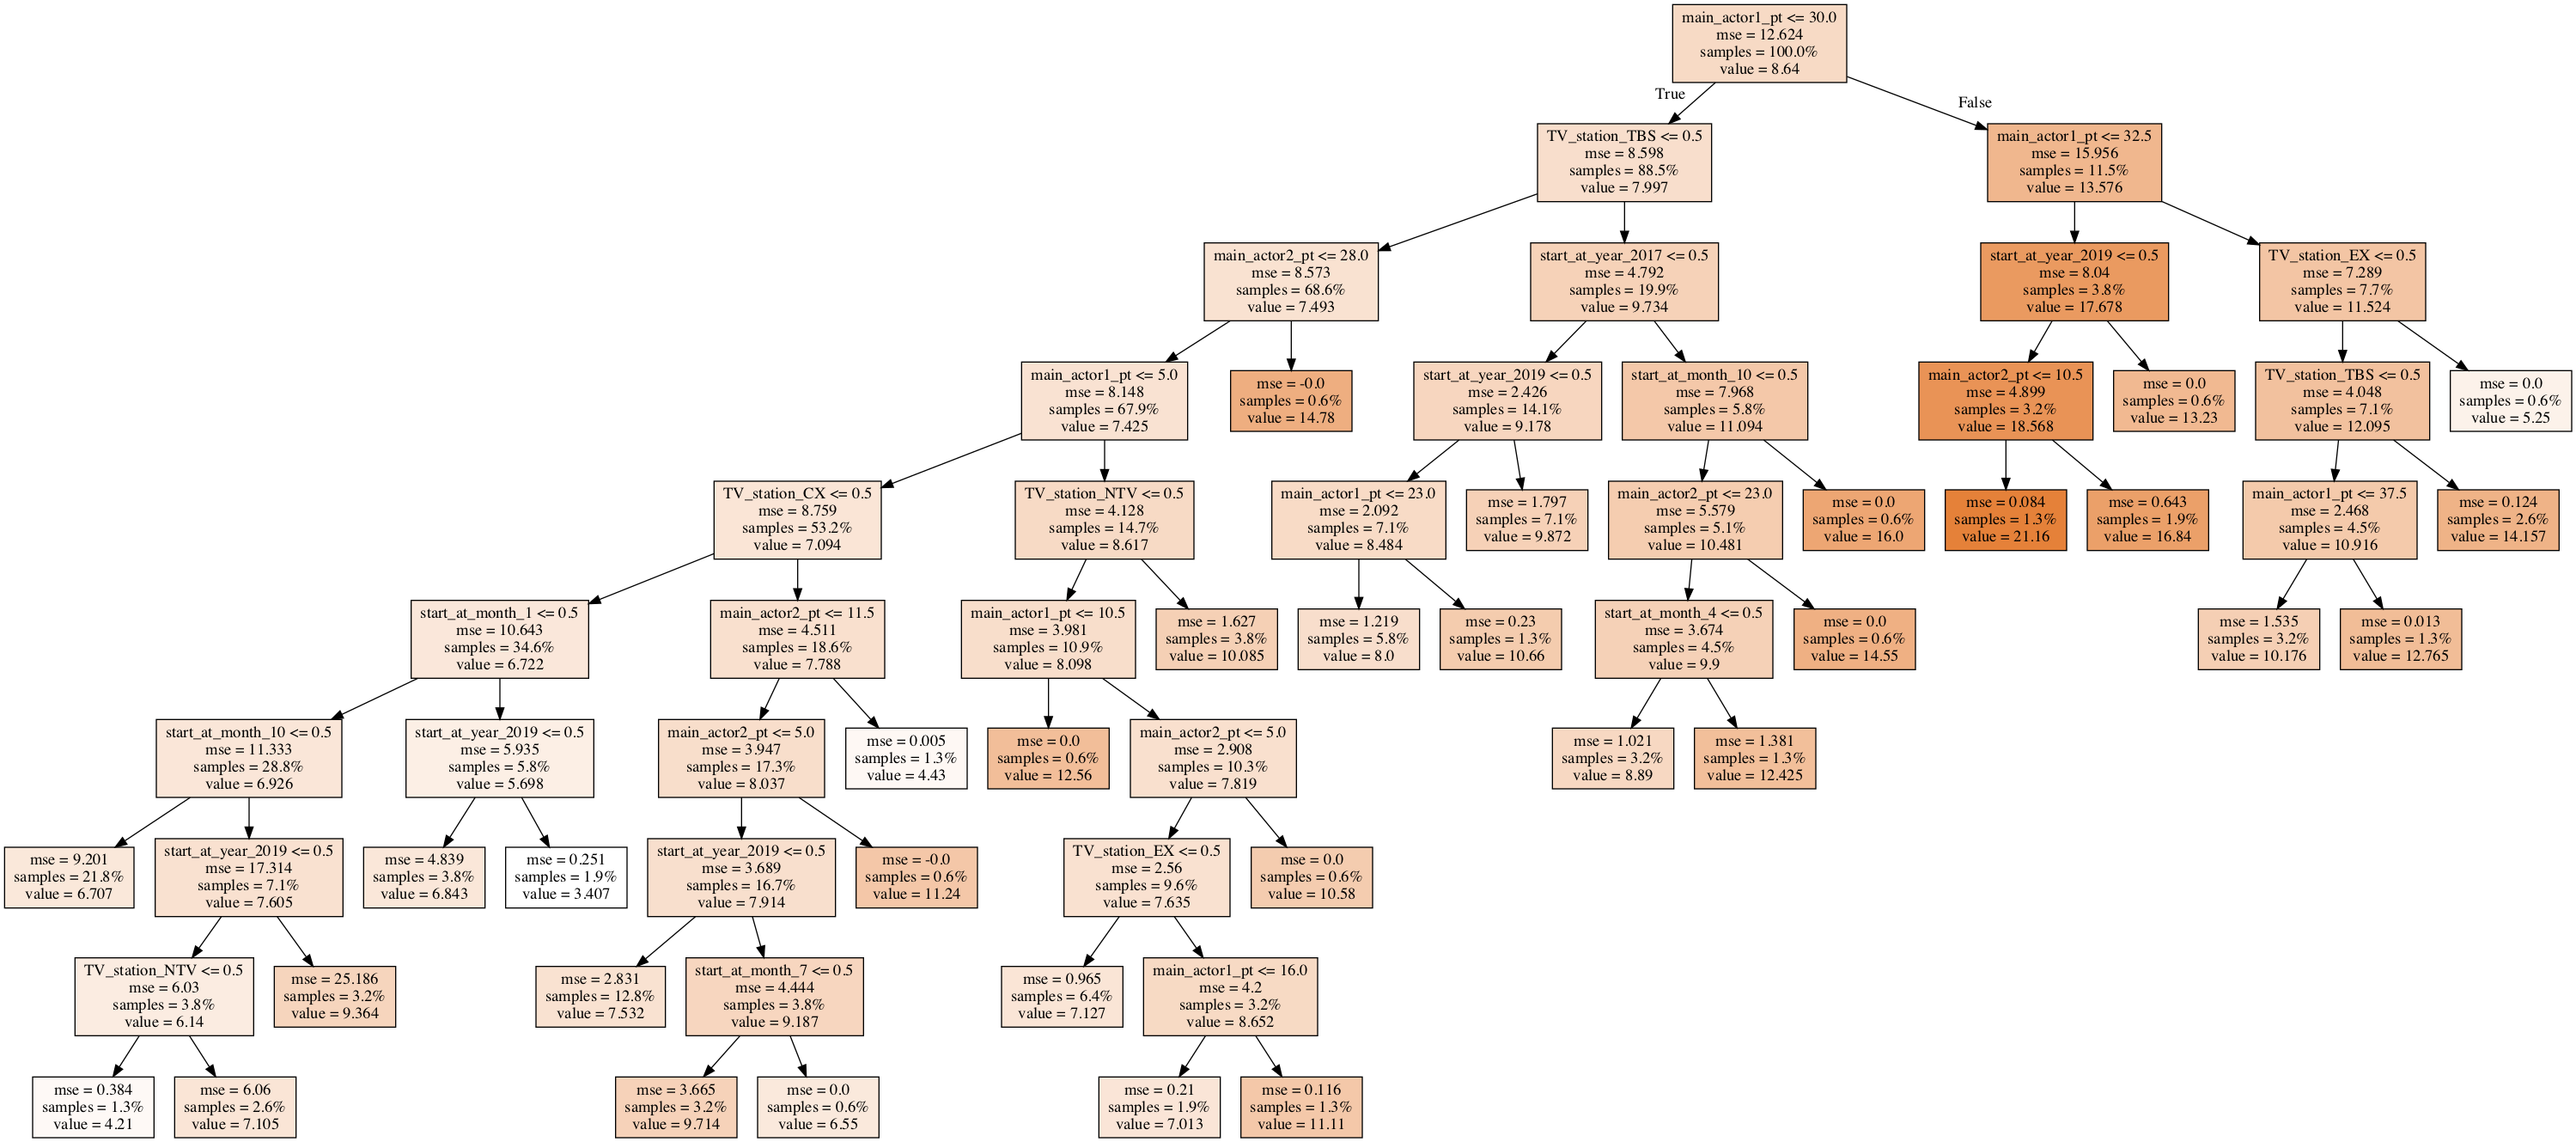

In [90]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names="average",
    filled=True,
    proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())